In [1]:
import numpy as np
import matplotlib.pyplot as plt
import string
import codecs
import re
import os.path

import unicodedata
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.metrics import accuracy_score

from tqdm import tqdm

import sys
sys.path.append('../src')

from modules import IDC
from utils import get_synthetic_dataset, plot_synthetic_dataset, clustering_accuracy
from trainer import idc_trainer, device
import json
import torch
import warnings
import torch.nn as nn
warnings.filterwarnings("ignore")

In [2]:
def load_movies_small(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe

    return np.array(alltxts),np.array(labs)


def preprocess(text):
    # un mot syntaxiquement correcte
    text = supp_punc_chiffre(text)
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    text = text.lower()
    return text.replace("."," ")

def supp_punc_chiffre(chaine) :
    chaine = supp_punc(chaine)
    chaine = re.sub('[0-9]',"", chaine)
    return chaine

def supp_punc(chaine) :
    punc = string.punctuation
    punc += '\n\r\t'
    chaine = chaine.translate(str.maketrans(punc, ' ' * len(punc)))
    return chaine

In [3]:
path = "data/movies1000/"
data_small,label_small = load_movies_small(path)
data_small = np.array([preprocess(doc) for doc in data_small])

In [4]:
vectorizer = TfidfVectorizer(stop_words='english',max_df=0.8, min_df=10)
X_vectorizer = vectorizer.fit_transform(data_small)
vocabulary_words = vectorizer.get_feature_names_out()

print(vocabulary_words)
X_vectorizer = torch.tensor(X_vectorizer.toarray(),dtype=torch.float32)
X_vectorizer.size()

['aaron' 'abandon' 'abandoned' ... 'zombie' 'zone' 'zooms']


torch.Size([2000, 7816])

# Model

In [5]:
data_input_dim = X_vectorizer.shape[1]
ae_layer_dims = [data_input_dim, 2048, 512, 2048, 2]
gnn_hidden_dim = data_input_dim
cluster_hidden_dim = 2048
nb_classes = 2

idc = IDC(data_input_dim, ae_layer_dims, gnn_hidden_dim, cluster_hidden_dim, nb_classes)

In [6]:
ae_gnn_config_train = {
    "batch_size":100, 
    "lr":1e-3,
    "local_gates_lmbd": 100,
    "reg_lmbd": 100,
    "eps": 1,
    
    "epochs":150,
    "end_pretrain_epoch": 100,
}

clust_config_train = {
    "batch_size":100, 
    "lr_cluster_head": 1e-2,
    "lr_aux": 1e-1,
    "lr_zg": 1e-1,
    "gamma": 4,
    "global_gates_lmbd": 10,
    "tau": 100,
    
    "epochs": 200,
    "end_pretrain_epoch": 100
}

training_result = idc_trainer(idc, X_vectorizer, ae_gnn_config_train, clust_config_train)

2024-02-11 18:43:25.701021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-11 18:43:25.814121: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-11 18:43:27.216155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64:/usr/local/cuda-12.2/lib64
2024-02-11 18:43:27.216340: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror:

--------------------------------
Stage One Starting :


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [09:58<00:00,  3.99s/it]


Stage One Finishing
--------------------------------

--------------------------------
Stage Two Starting :


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [19:30<00:00,  5.85s/it]

Stage Two Finishing
--------------------------------


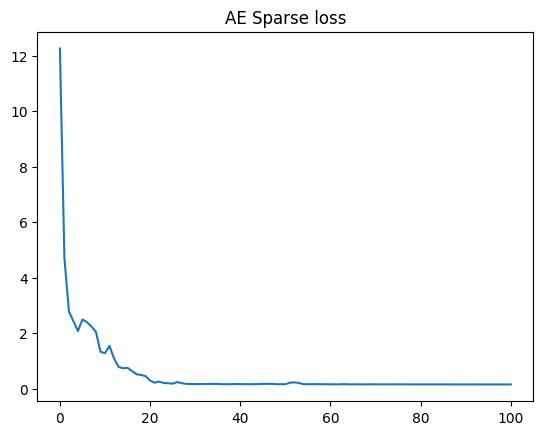

In [14]:
plt.plot(training_result["stage_one"]["ae_sparse_losses"])
plt.title("AE Sparse loss")
plt.show()

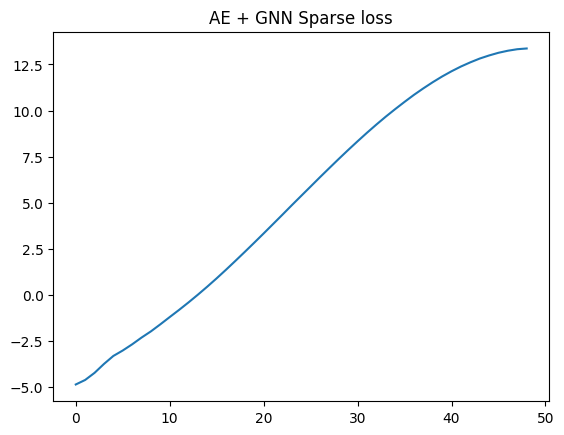

In [15]:
plt.plot(training_result["stage_one"]["ae_gnn_sparse_losses"])
plt.title("AE + GNN Sparse loss")
plt.show()

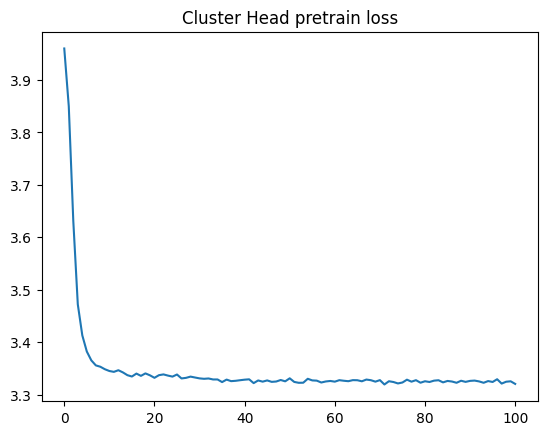

In [16]:
plt.plot(training_result["stage_two"]["clust_head_pretrain_losses"])
plt.title("Cluster Head pretrain loss")
plt.show()

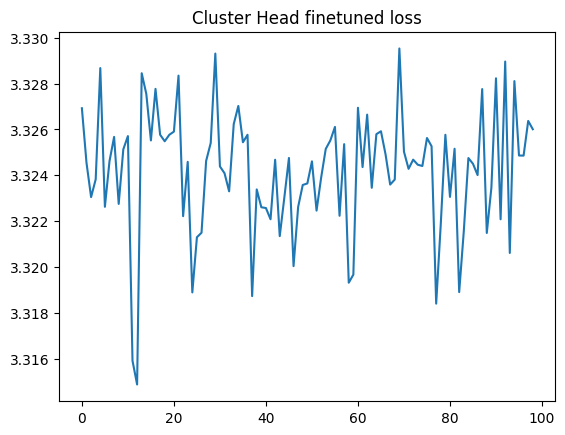

In [17]:
plt.plot(training_result["stage_two"]["clust_head_finetune_losses"])
plt.title("Cluster Head finetuned loss")
plt.show()

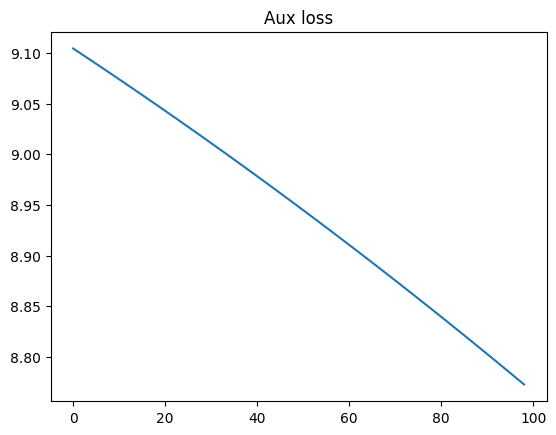

In [18]:
plt.plot(training_result["stage_two"]["aux_losses"])
plt.title("Aux loss")
plt.show()

In [19]:
with torch.no_grad():
    X = X_vectorizer.to(device)
    X_Z ,z , _ = idc.gnn(X)
    H = idc.ae.encoder(X_Z)

    clust_logits, aux_logits, u_zg = idc.clusterNN(X_Z, H)
    yhat = clust_logits.argmax(dim=1).cpu()

    print(clustering_accuracy(yhat, label_small))
    print(np.unique(yhat, return_counts=True))

0.503
(array([0, 1]), array([ 524, 1476]))


In [20]:
from sklearn.cluster import KMeans

km = KMeans(10)

km.fit(X_vectorizer)
yhat = km.predict(X_vectorizer)

clustering_accuracy(yhat, label_small)

0.3895

In [ ]:
torch.save(idc, "../models/movies_model.pth")